In [6]:
#@title Imports and defaults
%matplotlib inline

#from google3.pyglib import gfile
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

#from colabtools import adhoc_import
#with adhoc_import.Google3CitcClient("bandits", "bkveton"):
#  from google3.experimental.users.bkveton.bandits.deep import *
#import deep
from deep import *

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.8.3
matplotlib 3.2.2


In [4]:
#@title Bandit simulator
def evaluate_one(Alg, params, env, n, period_size=1):
  """One run of a bandit algorithm."""
  alg = Alg(env, n, params)

  regret = np.zeros(n // period_size)
  for t in range(n):
    # generate state
    env.randomize()

    # take action
    arm = alg.get_arm(t)

    # update model and regret
    alg.update(t, arm, env.reward(arm))
    regret_at_t = env.regret(arm)
    regret[t // period_size] += regret_at_t

  return regret, alg


def evaluate(Alg, params, env, n=1000, period_size=1, printout=True):
  """Multiple runs of a bandit algorithm."""
  if printout:
    print("Evaluating %s" % Alg.print(), end="")
  start = time.time()

  num_exps = len(env)
  regret = np.zeros((n // period_size, num_exps))
  alg = num_exps * [None]

  dots = np.linspace(0, num_exps - 1, 100).astype(int)
  for ex in range(num_exps):
    output = evaluate_one(Alg, params, env[ex], n, period_size)
    regret[:, ex] = output[0]
    alg[ex] = output[1]

    if ex in dots:
      if printout:
        print(".", end="")
  if printout:
    print(" %.1f seconds" % (time.time() - start))

  if printout:
    total_regret = regret.sum(axis=0)
    print("Regret: %.2f +/- %.2f (median: %.2f, max: %.2f, min: %.2f)" %
      (total_regret.mean(), total_regret.std() / np.sqrt(num_exps),
      np.median(total_regret), total_regret.max(), total_regret.min()))

  return regret, alg

python 3.8.3
tf 2.3.1
keras 2.4.0
Preprocessing dataset mnist...
60000 examples, 784 features, 10 labels
Evaluating DeepFPL. 78.7 seconds
Regret: 5347.00 +/- 0.00 (median: 5347.00, max: 5347.00, min: 5347.00)
Reward in last 1000 rounds: 533.00 +/- 0.00
Evaluating DeepFPL. 32.9 seconds
Regret: 5535.00 +/- 0.00 (median: 5535.00, max: 5535.00, min: 5535.00)
Reward in last 1000 rounds: 570.00 +/- 0.00
Evaluating NeuralLinear. 48.9 seconds
Regret: 5227.00 +/- 0.00 (median: 5227.00, max: 5227.00, min: 5227.00)
Reward in last 1000 rounds: 555.00 +/- 0.00


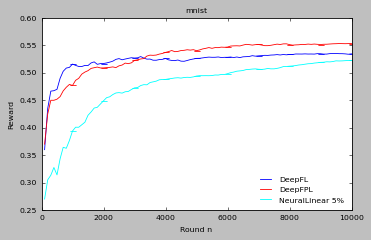

python 3.8.3
tf 2.3.1
keras 2.4.0
Preprocessing dataset fashion_mnist...
60000 examples, 784 features, 10 labels
Evaluating DeepFPL. 36.1 seconds
Regret: 4900.00 +/- 0.00 (median: 4900.00, max: 4900.00, min: 4900.00)
Reward in last 1000 rounds: 505.00 +/- 0.00
Evaluating DeepFPL. 41.4 seconds
Regret: 5233.00 +/- 0.00 (median: 5233.00, max: 5233.00, min: 5233.00)
Reward in last 1000 rounds: 533.00 +/- 0.00
Evaluating NeuralLinear

In [ ]:
# experiments
#num_runs = 20
num_runs = 1
n = 10000

# neural nets
hidden_nodes = "50"
hidden_activation = "relu"
optimizer = "adam"
lr = 0.001
batch_size = 32
deeps = [
  ("DeepFPL",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "optimizer": optimizer, "lr": lr, "batch_size": batch_size},
  "blue", "-", "DeepFL"),
  ("DeepFPL",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "optimizer": optimizer, "lr": lr, "batch_size": batch_size, "a": 1.0},
  "red", "-", "DeepFPL"),
  ("NeuralLinear",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "lr": lr, "batch_size": batch_size, "a": 1.0, "relepe": int(0.05 * n)},
  "cyan", "-", "NeuralLinear 5%")]

step = 100 * (np.arange(n // 100) + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

for dataset in ["mnist", "fashion_mnist"]:
  # create environment
  X, y = load_dataset(dataset)
  num_labels = int(y.max()) + 1

  for alg in deeps:
    env = []
    for run in range(num_runs):
      c = run % num_labels
      env.append(BinaryClassBandit(X, y, pos_label=c, K=10, pos_prob=0.75))

    alg_class = globals()[alg[0]]
    reward, _ = evaluate(alg_class, alg[1], env, n)
    print("Reward in last %d rounds: %.2f +/- %.2f" %
      (n // 10, reward[- n // 10 :, :].sum(axis=0).mean(), \
      reward[- n // 10 :, :].sum(axis=0).std() / np.sqrt(num_runs)))

    cum_reward = reward.cumsum(axis=0)[step - 1, :] / step[:, np.newaxis]
    plt.plot(step, cum_reward.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
    plt.errorbar(step[sube], cum_reward[sube, :].mean(axis=1),
      cum_reward[sube, :].std(axis=1) / np.sqrt(cum_reward.shape[1]),
      fmt="none", ecolor=alg[2])

  plt.title("%s" % dataset)
  plt.xlabel("Round n")
  plt.ylabel("Reward")
  plt.legend(loc="lower right", frameon=False)
  plt.show()

In [12]:
env[0].X.shape

(10, 784)